# Agentic workflow ( Prompt sequencing pattern) using two agents created in FloTorch

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FloTorch/Resources/blob/main/examples/flotorch-rag-notebooks/faiss-example/03_ContentWriter.ipynb)
    
This notebook demonstrates an agentic workflow using two agents in the prompt sequencing agent. In this pattern the response of the first agent in the workflow ends up being the message input to the second agent.

(_Prompt Sequencing Pattern as explained by [Anthropic here](https://www.anthropic.com/engineering/building-effective-agents)_)
![Prompt Sequencing - as shown in Anthropic article](https://www.anthropic.com/_next/image?url=https%3A%2F%2Fwww-cdn.anthropic.com%2Fimages%2F4zrzovbb%2Fwebsite%2F7418719e3dab222dccb379b8879e1dc08ad34c78-2401x1000.png&w=3840&q=75)

In this notebook the agents involved are created in [Flotorch](https://console.flotorch.cloud) are "**topic-creator**" and "**content-writer**"

## Key Benefits of FloTorch Integration:
* All the interactions happening in our agentic workflow is monitorable through FloTorch Console.
* Creation and maintenance of the Agent is easier strategically using FloTorch console. In future we might tweak or even change the Agent configuration in FloTorch Console, without having to make any updates to this notebook. This helps in managing resilience and security changes without needing global changes in the code we have written.
* Insights are available on the usage and cost implications of the LLM models utilized by the agents within out FloTorch Console dashboard.


## Steps to use the FloTorch agents and orchestrate an agentic workflow using Google ADK as the orchestration framework:

Step 1: Install Required Packages

Step 2: Import the libraries

Step 3: Set your API keys

Step 4: Define a local function to help extract txt for given pdf.

Step 5: Set up the agentic clients using agents defined in [FloTorch Console] (https://console.flotorch.cloud)

Step 6: Set up session and runners for the agents

Step 7: Create a single run method to run the agents.

Step 8: Define the agentic workflow

Step 9: Run the agentic workflow






### Step 1: Install required packages

In [ ]:
%pip install PyPDF2 sentence-transformers python-dotenv faiss-cpu requests numpy

### Step 2: Import libraries & setup

In [ ]:
%pip install flotorch

In [ ]:
# Mount Google Drive and set path
from google.colab import drive
drive.mount('/content/drive')

import os
import sys

# Navigate to your notebook directory
os.chdir('/content/drive/MyDrive/Colab Notebooks')
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
%mkdir -p FloTorch
%cd FloTorch
!git clone https://github.com/FloTorch/Resources.git
os.chdir("/content/drive/MyDrive/Colab Notebooks/FloTorch/Resources/examples/flotorch-rag-notebooks/faiss-example")
%ls

In [ ]:
import os
import random
import time
import json
import sys
import requests
from typing import List

import PyPDF2
from sentence_transformers import SentenceTransformer
#import faiss
#from utils import extract_text_from_pdf

print("✅ All libraries imported successfully!")

In [ ]:
# --- Imports from Flotorch ADK and Google ADK ---
from flotorch.adk.agent import FlotorchADKAgent       # Flotorch wrapper for creating an ADK agent
from flotorch.adk.sessions import FlotorchADKSession # Flotorch session service (integrates with Flotorch Gateway sessions)
from google.adk import Runner                         # Runs the agent with a session
from google.genai import types                        # Data types for message content


### Step 3: Set your API keys
**Important**
1. Replace the API key with your actual FloTorch API Key (Check [Prerequisites.ipynb](./01_Prerequisites.ipynb) on how to get the key)
2. Using FloTorch helps you monitor the agentic flow through the FloTorch gateway.


In [ ]:
from getpass import getpass
# SET YOUR FLOTORCH API KEY HERE

FLOTORCH_API_KEY = getpass("FloTorch API Key") # Replace with your actual Flotorch API key

#### Configuration setup

In [ ]:
# --- FloTorch Configuration for Gateway and Agents ---
APP_NAME = "flotorch_agent_example"         # Name of the app (used in session tracking)
USER_ID = "flotorch_user_123"               # Unique ID for the user
FLOTORCH_GATEWAY_BASE_URL = "https://gateway.flotorch.cloud"              # Base URL of the Flotorch Gateway
FLOTORCH_AGENT_NAME_TOPIC_CREATOR = "topic-creator"                     # Name of the agent configured in Flotorch
FLOTORCH_AGENT_NAME_CONTENT_WRITER = "content-writer"                     # Name of the agent configured in Flotorch


### Step 4: Define a local function to help extract txt for given pdf

The local function get_pdf_text() is in turn calling a function from utils to extract the content of the pdf. The function, when invoked as a tool by the agent, will request us to input the pdf path. This path is then used by the function in utils to extract text from.

For eg. you can use the following pdf file and path to test - https://arxiv.org/pdf/2405.00001


In [ ]:
def extract_text_from_web_pdf(pdf_url):

    # --- Imports ---
    import requests
    #from pypdf import PdfReader
    import io
    import os

    max_chars_to_display = 200 # Set how much extracted text to print

    # --- Processing and Extraction ---
    try:
        # 4b. Use requests to get the content
        response = requests.get(pdf_url, stream=True)
        response.raise_for_status() # Check for bad status codes (4xx or 5xx)

        pdf_in_memory = io.BytesIO(response.content)

        # 4d. Initialize the PdfReader
        reader = PyPDF2.PdfReader(pdf_in_memory)

        # Check if the PDF is encrypted (optional but robust)
        if reader.is_encrypted:
            print("⚠️ Warning: The PDF is encrypted. Cannot extract text without a password.")
            # If you have a password, you would use: reader.decrypt('your_password')
            total_text = "Extraction failed (Encrypted)."
        else:
            # 4e. Extract text page by page
            total_pages = len(reader.pages)
            print(f"Total pages found: {total_pages}")

            extracted_text = []
            for i in range(total_pages):
                page = reader.pages[i]
                # The 'extract_text()' method is common across pypdf/PyPDF2
                text = page.extract_text()
                if text:
                    extracted_text.append(text)

            # Combine all text
            total_text = "\n".join(extracted_text)

            print(f"✅ Extraction complete! Total text length: {len(total_text)} characters.")
            return total_text

    except requests.exceptions.RequestException as e:
        print(f"\n❌ Error during download: {e}")
        return "Extraction failed"
    except Exception as e:
        print(f"\n❌ An error occurred during PDF processing: {e}")
        return "Extraction failed"


  For the get_pdf_text() function below keep a link to an online pdf ready. In case you want a ready example you can set pdf_url = "https://arxiv.org/pdf/2405.00001"  or pdf_url = "https://desapublications.un.org/sites/default/files/publications/2024-03/WESP%202024_Executive%20Summary_0.pdf"

  **NOTE**: This tool works exclusively with online pdfs. It is not for local pdfs.


In [ ]:
def get_pdf_text():
    pdf_url = input("Enter the path to the PDF file: ")
    response = extract_text_from_web_pdf(pdf_url)
    print(response)
    return response

### Step 5: Set up the agentic clients using agents defined in [FloTorch Console](https://console.flotorch.cloud)

#### **Prerequisites - Agents need to be created and published on [FloTorch Console](https://console.flotorch.cloud)**

##### **Steps to create an agent in FloTorch**
1. Open [FloTorch Console](https://console.flotorch.cloud) and click on the Agent Builder option within the Agent menu.

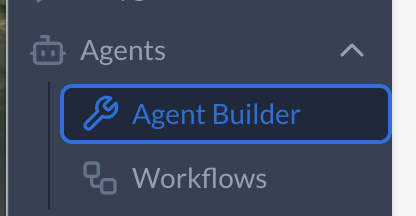

2. Click on "Create FloTorch Agent" button


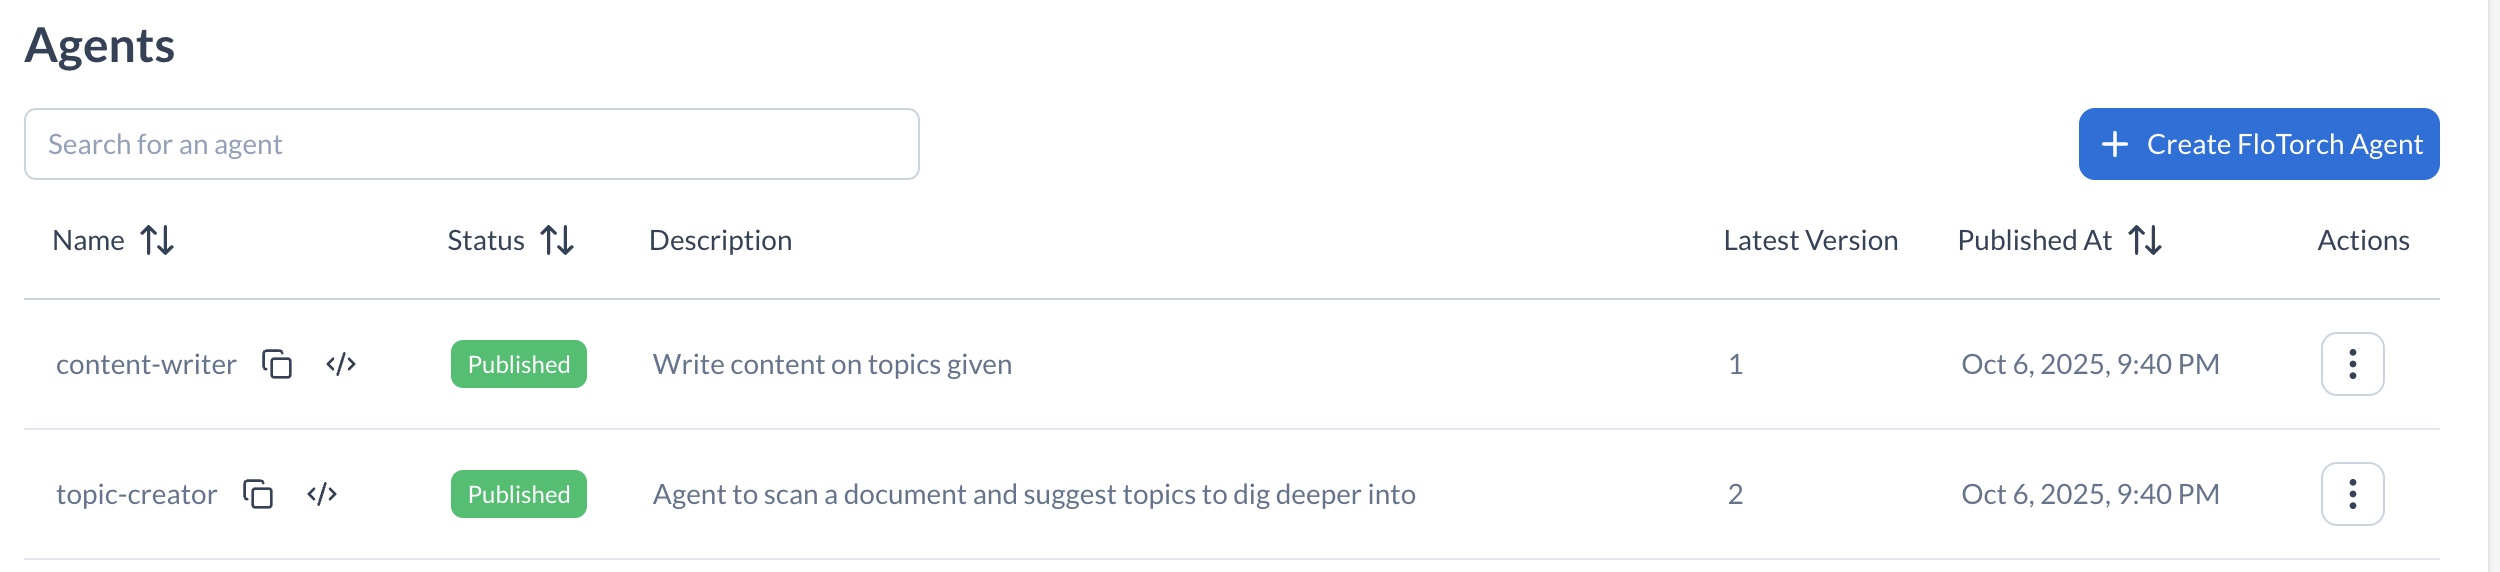
3. This opens the Agent Builder studio with a design canvas on which you can set up your agent by adding agent configuration, adding associated LLM, and optionally adding tools as well as input and output schema.
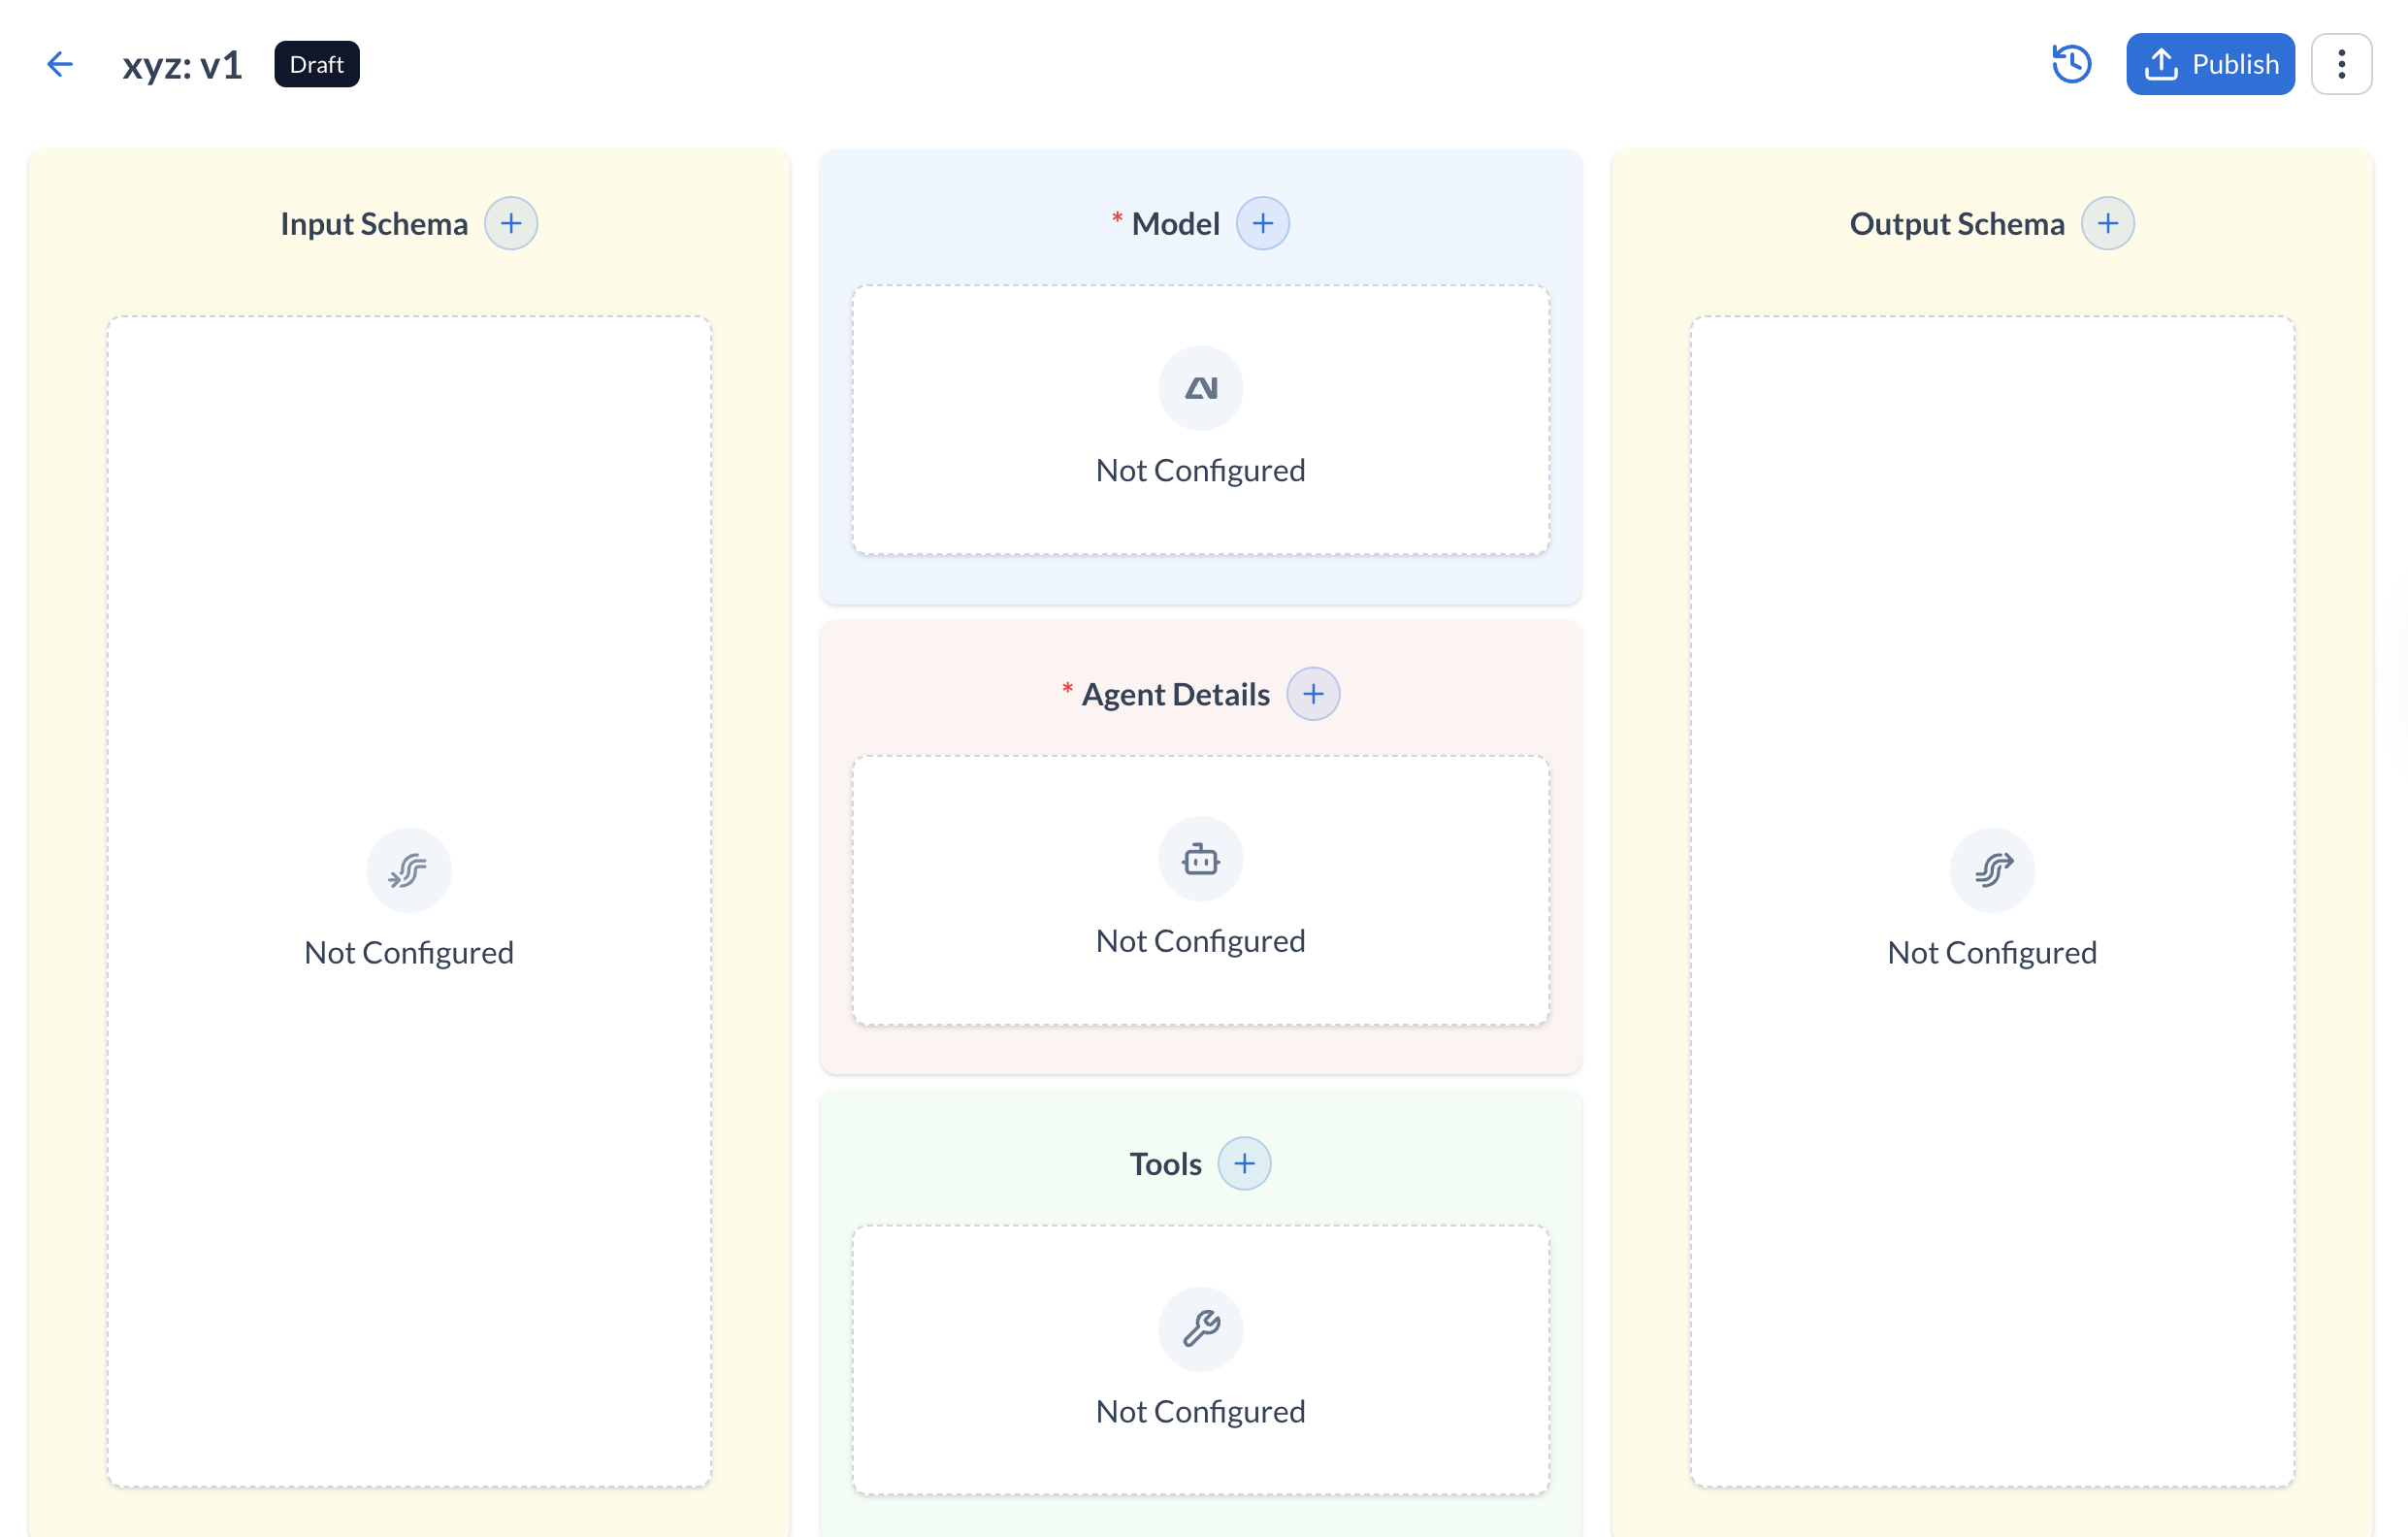
4. Once configuration is done as per suggested values below, you will complete the creation and make the agent available to be called through your code by clicking on publishing, and ensuring to click on "mark as latest" when clicking on Publish in the Add Summary screen.



#### **Plan for our agentic flow**
- We need two agents, "**topic-creator**" and "**content-writer**".

- The "topic-creator" agent will parse pdf given to it using a local tool, and get a text extract. It will then review the extracted content and choose 5 key topics from the content. This set of topics will then be passed onto next agent as output.

- The next agent in the prompt sequencing queue will be "content-writer" agent. The input for this agent will be the set of topics. This agent will take each topic for this set, and write a couple of more paragraphs on the topic. This list of agent created content for each topic will be the final output of our workflow



---





##### **Details needed to create "topic_creator" agent**
When creating the "topic-creator" agent configure it using the details given below:
* System Prompt suggested:
  ```
    You are an AI document analysis agent. Your task is to analyze the content of a provided document and identify the 5 most relevant or important topics from the subject matter. These topics should represent distinct, meaningful concepts or areas of discussion covered in the document. Output the topics in a JSON format.

    Guidelines:

    Focus on identifying distinct and non-overlapping topics.

    Prefer high-level concepts or key entities over generic terms.

    Avoid vague or overly broad terms like "general information" or "miscellaneous".

    Order the topics by relevance or prominence in the document.

    Output the results as a JSON object with the key "topics" and a list of strings as the value.

    Example output:

    {
    "topics": [
    "Climate change policy",
    "Carbon emission trading",
    "Renewable energy investments",
    "UN climate summits",
    "Global temperature targets"
    ]
    }
    ```
* Goal suggested:
    ```
    The AI agent reads a document, identifies the 5 most relevant or interesting topics based on its content, and outputs them in a JSON format. These topics should reflect the core themes, ideas, or areas of importance in the text.

    Intended Use:
    The extracted topics can be used for summarization, or as seed topics or categories for writing content on.
    ```
* Model:
    ```
    Any flotorch model in your environment - suggestion is to use a lightwight yet good model like "gemini 2.5 flash" within the chosen FloTorch model.
    ```
* Output schema suggested:

    ```
    {"$schema":"https://json-schema.org/draft/2020-12/schema","type":"object","properties":{"topics":{"type":"array","items":{"type":"string"}}},"required":["topics"],"additionalProperties":false}
    ```



---


*Screenshot showing the configuration of the agent.*:

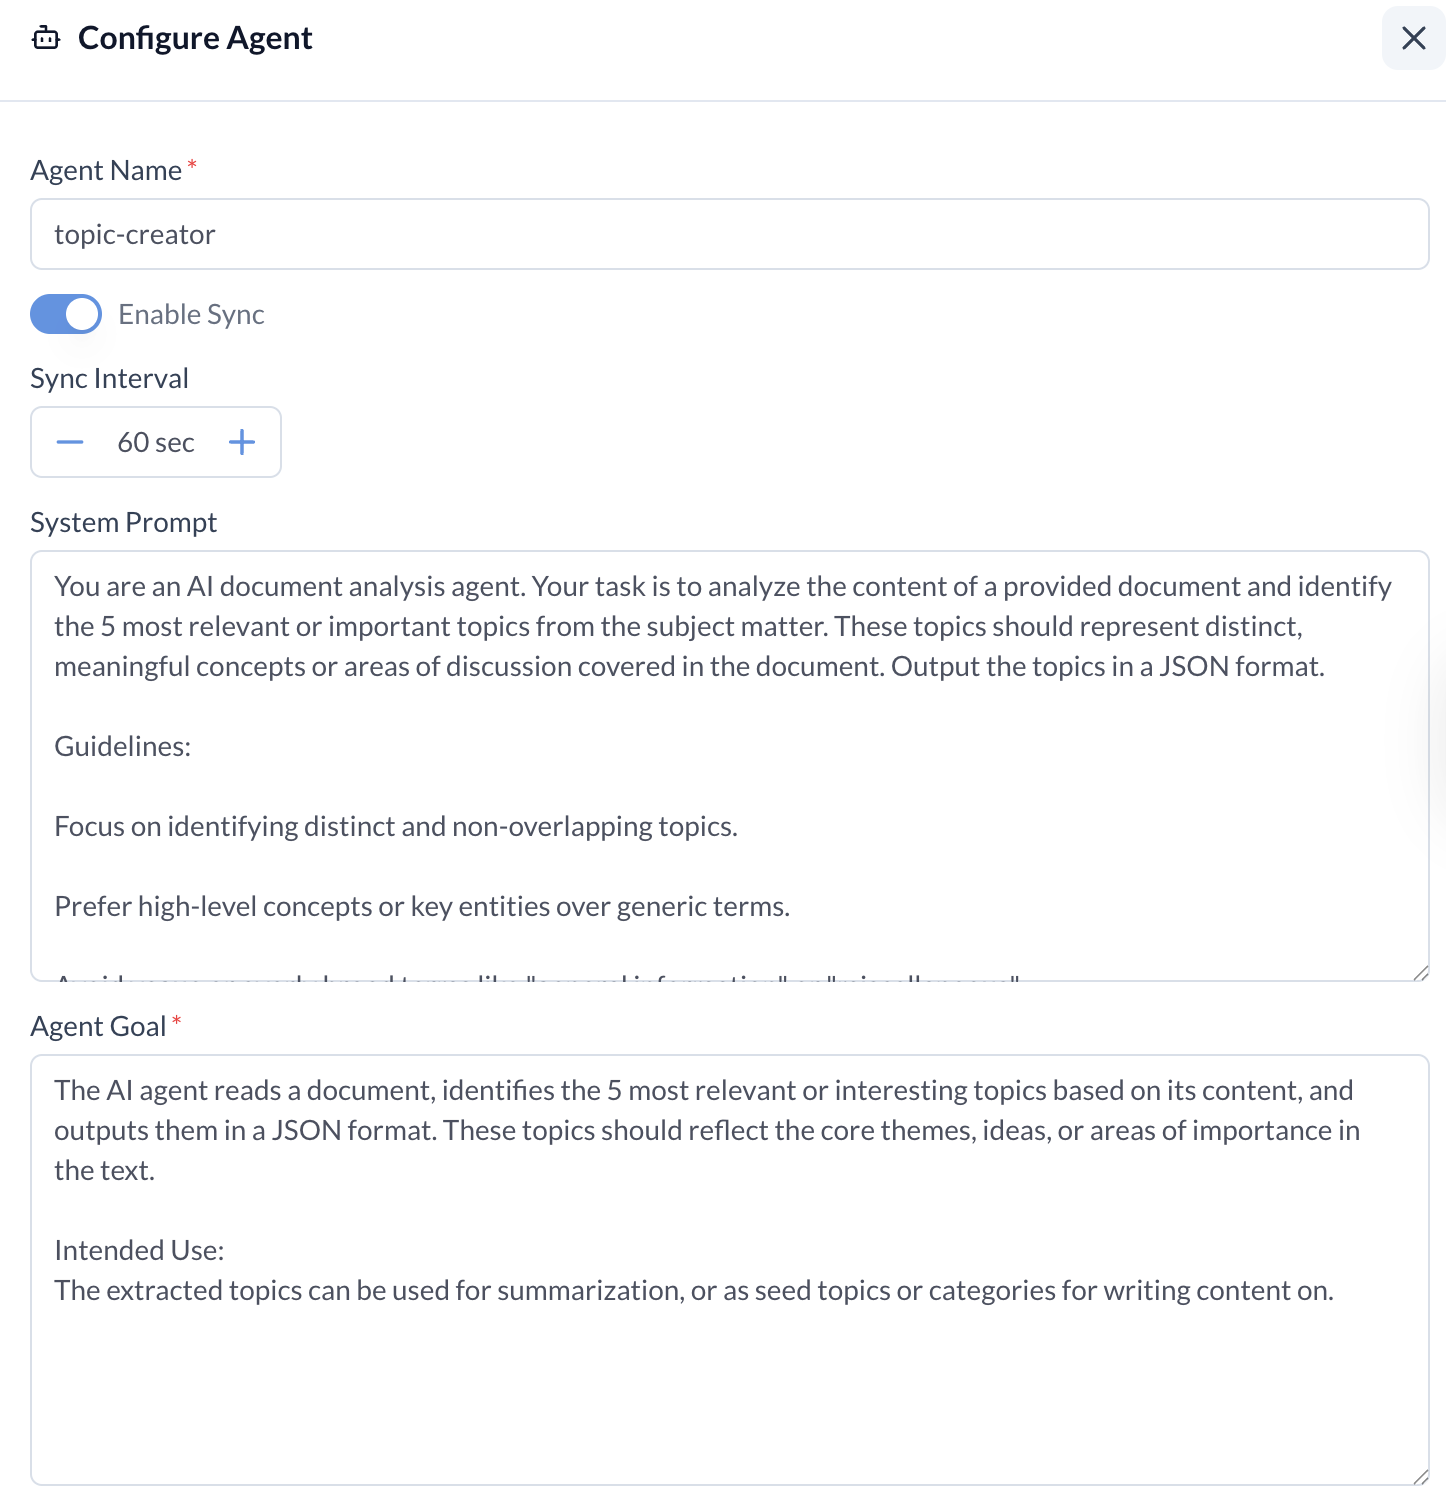
---


##### **Details needed to create "content-writer" agent**
When creating the "content-writer" agent, configure it using the details given below:
* System Prompt suggested:
    ```
    You are a professional content writing assistant.
    Your task is to generate informative and engaging content based on a list of topics.
    For each topic, write 2 to 3 well-structured paragraphs that:

    Clearly explain the core idea or concept behind the topic.

    Highlight the key insights or relevance of the topic today.

    Suggest potential directions for further reading or exploration, such as related subtopics, questions, or recent developments.

    Write in a clear, professional tone suitable for a general audience interested in learning or exploring the topic further. Avoid overly technical language unless necessary, and provide smooth transitions between points.
    ```
* Goal suggested:
    ```
    The goal of this content writing agent is to transform a list of topics into informative, well-structured text blocks that:

    Provide foundational understanding of each topic.

    Engage readers by emphasizing relevance and key takeaways.

    Inspire further curiosity by hinting at deeper questions or next steps in learning.

    The agent should aim to make each topic accessible, intriguing, and valuable to readers seeking quick yet meaningful insights.
    ```
* Model:
    ```
    Any flotorch model in your environment - suggestion is to use a lightweight yet good model like "gemini 2.5 flash" within the chosen FloTorch model.
    ```




* Input schema suggested:

    ```
    {"$schema":"https://json-schema.org/draft/2020-12/schema","type":"object","properties":{"topics":{"type":"array","items":{"type":"string"}}},"required":["topics"],"additionalProperties":false}
    ```



---


*Screenshot of agent configuration*


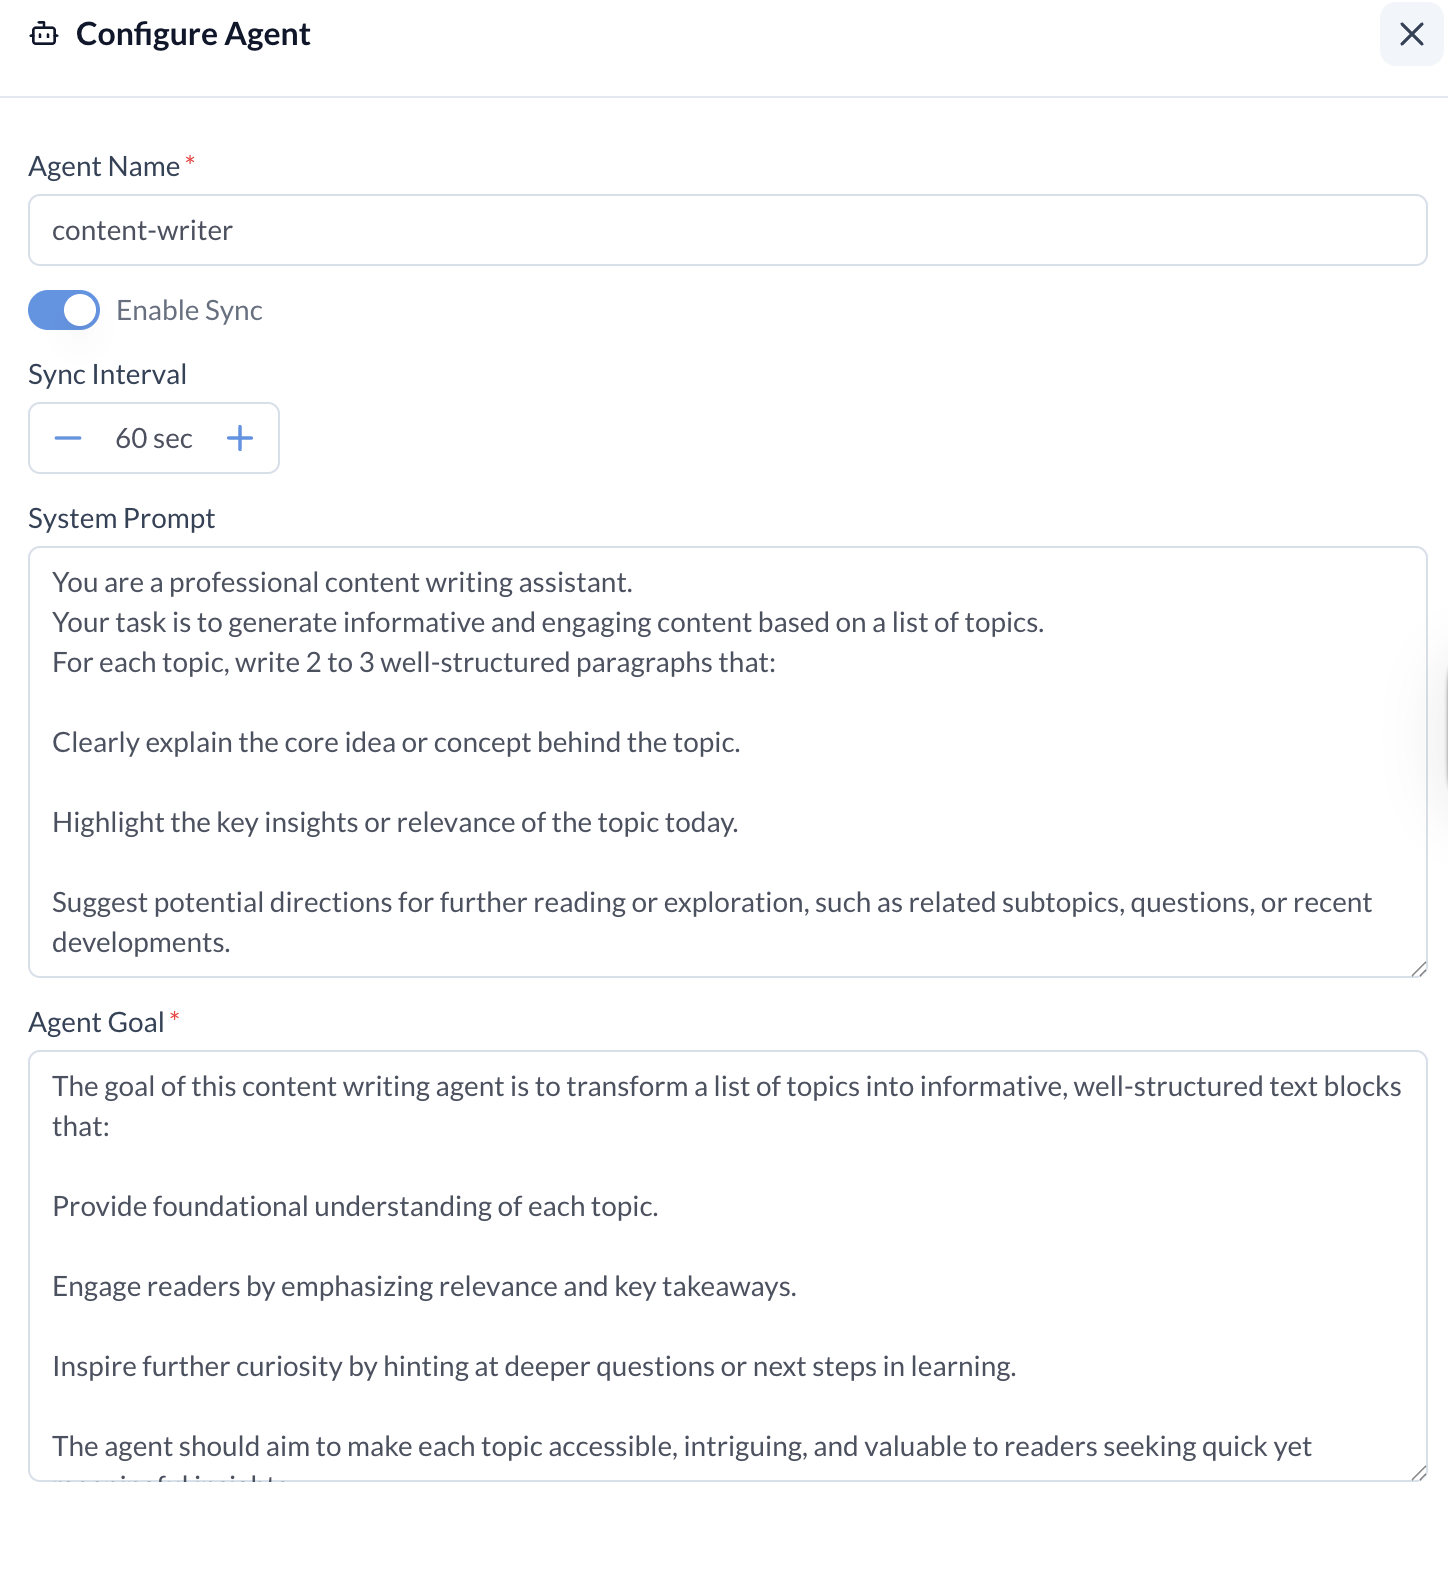



---



#### Note about FloTorch ADK Agent Client setup
We are creating agent clients using FloTorch ADK. While the configuration is pretty self explanatory please note the addition of ***custom_tools*** in the "topic-creator" agent configuration.

This addition of custom tools is how we connect a local tool to an agent, which the agent can then call on in runtime.

In [ ]:
# --- Create Flotorch ADK Agent Client for topic-creator---
# This object will fetch the agent definition from the Flotorch Gateway for topic-creator agent

flotorch_adk_client = FlotorchADKAgent(
    agent_name=FLOTORCH_AGENT_NAME_TOPIC_CREATOR,
    enable_memory=False,                     # Disable memory for this example (can be True to persist chat context for long term)
    base_url=FLOTORCH_GATEWAY_BASE_URL,
    api_key=FLOTORCH_API_KEY,
    custom_tools = [get_pdf_text]
)

# Get the agent object from Flotorch ADK
topic_creator_agent = flotorch_adk_client.get_agent()

# --- Create Flotorch ADK Agent Client for content-writer---
# This object will fetch the agent definition from the Flotorch Gateway for content-writer agent

flotorch_adk_client_content_writer = FlotorchADKAgent(
    agent_name=FLOTORCH_AGENT_NAME_CONTENT_WRITER,
    enable_memory=False,                     # Disable memory for this example (can be True to persist chat context for long term )
    base_url=FLOTORCH_GATEWAY_BASE_URL,
    api_key=FLOTORCH_API_KEY
)

# Get the agent object from Flotorch ADK
content_writer_agent = flotorch_adk_client_content_writer.get_agent()


### Step 6: Set up session and runners for the agents


In [ ]:
# --- Setup Session Service ---
session_service = FlotorchADKSession(api_key=FLOTORCH_API_KEY, base_url=FLOTORCH_GATEWAY_BASE_URL)

# --- Create Runner ---
# Runner manages the conversation loop between the agent and the user
runner1 = Runner(
    agent=topic_creator_agent,
    app_name=APP_NAME,
    session_service=session_service
)

In [ ]:
runner2 = Runner(
    agent=content_writer_agent,
    app_name=APP_NAME,
    session_service=session_service
)


### Step 7: Create a method to run the agents with associated messages.


In [ ]:
# --- Function to send a single user message and get the final AI response ---
def run_single_turn(query, session_id, runner,user_id):
    """Send a message to the Flotorch agent and return the final response text."""
    # Create message content object (role=user, with text parts)
    content = types.Content(role="user", parts=[types.Part(text=query)])

    # Run the agent for this message in the given session
    events = runner.run(
        user_id=user_id,
        session_id=session_id,
        new_message=content
    )

    # Loop through the events to find the final response from the agent
    for event in events:
        if event.is_final_response():
            if event.content and event.content.parts:
                return event.content.parts[0].text  # Return the text from the first part

    return "Sorry, I couldn't process that."  # Fallback if no valid response


### Step 8: Define the agentic workflow
Create an async function to call the agents in sequence as part of our workflow

In [ ]:
# --- Async function to start an agentic session and consume a pdf ---
async def content_from_pdf(message):
    """Start a new session with the agent and send a single message."""
    # Create a new session for the user via Flotorch Gateway
    session = await runner1.session_service.create_session(
        app_name=APP_NAME,
        user_id=USER_ID,
    )

    message = "run the get_pdf_text tool to get the content from the pdf path and work as an agent on that content"

    # Send the message and get the response
    response_topic_creator = run_single_turn(message, session.id, runner1,USER_ID)

    # Print the conversation
    print(f"You: {message}")
    print(f"Flotorch AI: {response_topic_creator}")

    #return response_topic_creator

    session = await runner2.session_service.create_session(
        app_name=APP_NAME,
        user_id=USER_ID,
    )

    response_content_writer = run_single_turn(response_topic_creator, session.id, runner2,USER_ID)
    print
    print

    print(f"Flotorch AI: {response_content_writer}")

    return response_content_writer

### Step 9: Run the agentic workflow.
set up our user prompt and use it to call the agentic flow async function which in turn will call the runners and invoke the agents who will then try to fulfill their goals using the LLMs and tools associated to them.

In [ ]:
# --- Entry point ---
# Changed to call the synchronous function directly
if __name__ == "__main__":
   user_prompt = "run the get_pdf_text tool to get the content from the pdf path and work as an agent on that content"
   await(content_from_pdf(user_prompt))